https://www.researchgate.net/profile/Vito_Muggeo/publication/10567491_Estimating_Regression_Models_with_Unknown_Break-Points/links/5a34fda2aca27247eddd201e/Estimating-Regression-Models-with-Unknown-Break-Points.pdf

## Estimating regression models with unknown break-points

Tentative de traduction pour un physicien de l'article: "Estimating regression models with unknown break-points" de Vito M. R. Muggeo (2003).

### The simple model (one break-point)

On a une mesure $(X_i, Y_i)$, que l'on souhaite estimer par une fonction non linéaire de la forme:

$$
f_0(t) = a + b\,t + c\, ramp( t - t_0 )
$$

a, b, c et $t_0$ sont les constantes que l'ont cherche à estimer.

La fonction $ramp(  t - t_0 )$ est non-linéaire:
$$
ramp(  t - t_0 ) = max( t - t_0 ,\, 0 )
$$

Un dévellopement de Taylor au 1er ordre en $t - t_0$ avec $dt=t_1 - t_0$ permet d'écrire:
$$
ramp(x - dx) \sim ramp(x) + dx \left. \frac{d\, ramp(u)}{du} \right)_{x - dx}
$$

$$
ramp(t - t_1) \sim ramp(t - t_{0}) + (t_0 - t_{1}) \left. \frac{d\, ramp(u)}{du} \right)_{t - t_{0}}
$$

La derivée d'une rampe est une marche:
$$
\left. \frac{d\,ramp(u)}{du}\right)_{t-t_{0}} 
= step( t - t_{0} ) = Heaviside( t - t_{0} ) 
$$

Une second fonction théorique est alors obtenue:
$$
f_1(t) = a + b\,t + c\, ramp( t - t_{0} ) + c \, (t_0 - t_{1})\,step( t - t_{0} ) 
$$

En posant $d = c \, (t_0 - t_{1})$, et en utilisant cette fonction pour effectué le fit, la valeur de $t_1$ peut être itérativement estimée.

$$
t_1 = t_0 - \frac{d}{c} 
$$

"the process is iterated until possible convergence, which is not, in general, guaranteed"

- Critère de convergence: $t_1 - t_0 < pas\,de\, temps$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', size=12)
plt.rc('axes', labelsize=18)
plt.rc('lines', linewidth=2)

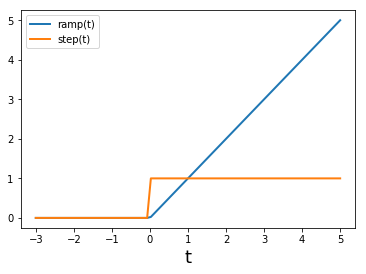

In [124]:
ramp = lambda u: np.maximum( u, 0 )
step = lambda u:  ( u > 0 ).astype(float)

t = np.linspace( -3, 5, 83 )
plt.plot( t, ramp(t), label='ramp(t)' )
plt.plot( t, step(t), label='step(t)' );
plt.xlabel('t'); plt.legend();

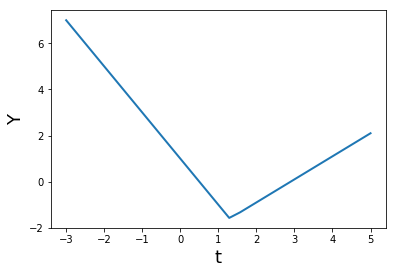

In [142]:
t = np.linspace( -3, 5, 29 )

Y = 3*ramp( t - 1.3 )  - 2*t + 1
plt.plot( t, Y ); plt.xlabel('t'); plt.ylabel('Y')

doc: https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html

In [143]:
from numpy.linalg import lstsq

0.401002506266
1.00614439324
1.29634171265
1.3
1.3


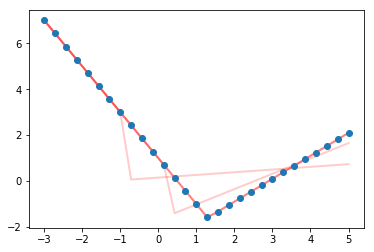

In [144]:
t0 = -1
X = t
ones = np.ones_like(X)
for k in range( 5 ):
    R, S = ramp( X - t0 ), step( X - t0 )
    A = np.array([ ones, X,  R, S  ])
    sol = lstsq(A.T, Y)
    a, b, c, d = sol[0]
    t1 = t0 - d/c
    plt.plot( t, ones*a + b*X + c*R + d*S, 'r', alpha=.2  )
    t0 = t1
    print(t1)
    
plt.plot( t, Y, 'o' )

## The multi-brekpoints case

The fitting function is now:
$$
f_0(t) = a + b\,t + \sum_k^N c_{k}\, ramp( t - t_{k, 0} )
$$

De la même façon:
$$
ramp(t - t_{k, 1}) \sim ramp(t - t_{k, 0}) + (t_{k, 0} - t_{k, 1}) \left. \frac{d\, ramp(u)}{du} \right)_{t - t_{k, 0}} \\
\sim  ramp(t - t_{k, 0}) + (t_{k, 0} - t_{k, 1}) \,step(t - t_{k, 0})
$$

et
$$
f_1(t) = a + b\,t + \sum_k^N c_{k}\, ramp( t - t_{k, 0} ) + c_{k}(t_{k, 0} - t_{k, 1}) \,step(t - t_{k, 0})
$$

Si $d_k =  c_{k}(t_{k, 0} - t_{k, 1}) $, on retrouve les $N$ nouveaux temps avec:
$$
t_{k, 1} =  t_{k, 0 }- \frac{d_k}{c_k} 
$$

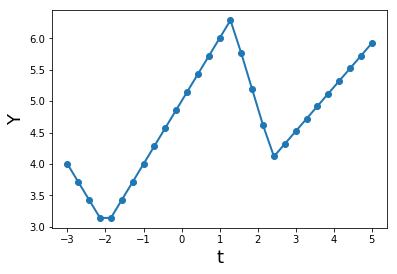

In [128]:
t = np.linspace( -3, 5, 29 )

Y = 1 - t + 2*ramp( t + 2 ) - 3*ramp( t - 1.3 )  + 2.7*ramp( t - 2.4 )
plt.plot( t, Y, '-o' ); plt.xlabel('t'); plt.ylabel('Y')

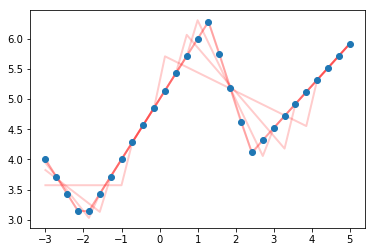

In [140]:
t0k = [-1, 0, 4]
X = t
ones = np.ones_like(X)

for k in range( 5 ):
    Rk = [ramp( X - tk ) for tk in t0k ]
    Sk = [step( X - tk ) for tk in t0k ]
    A = np.array([ ones, X ] + Rk + Sk )
    sol = lstsq(A.T, Y)
    params = list( sol[0] )
    
    a = params.pop(0)
    b = params.pop(0)
    ck = [ params.pop(0) for k in range(len(t0k)) ]
    dk = [ params.pop(0) for k in range(len(t0k)) ]
    t1k = [ t0 - d/c for t0, c, d in zip( t0k, ck, dk )   ]
    
    sumRamp = np.sum( [ c*ramp(t-t0) for t0, c in zip( t0k, ck) ], axis=0 )
    sumStep = np.sum( [ d*step(t-t0) for t0, d in zip( t0k, dk) ], axis=0 )
    Y1 = ones*a + b*X + sumRamp + sumStep
    plt.plot( t, Y1, 'r', alpha=.2  )
    t0k = t1k
    
plt.plot( t, Y, 'o' );

In [121]:
t0k

[-2.0000000000000009, 1.3000000000000009, 2.3999999999999999]

_note:_ les coefficients correspondent aux changement de pente, ce ne sont pas directement les pentes


et avec une Gaussienne? 